# DAY51

作者微信：shujinxing777


之前有同学问我之前对于权重的可视化有什么意义，我们现在来引入这个概念，从权重的初始化到权重的可视化

随着学习的越来越深入，有一些基础的概念我们往后就绕不过去了，还是得把基础打牢，介绍下这些概念。

## 随机种子

In [1]:
import torch
import torch.nn as nn

# 定义简单的线性模型（无隐藏层）
# 输入2个纬度的数据，得到1个纬度的输出
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # 线性层：2个输入特征，1个输出特征
        self.linear = nn.Linear(2, 1)
        
    def forward(self, x):
        # 前向传播：y = w1*x1 + w2*x2 + b
        return self.linear(x)

# 创建模型实例
model = SimpleNet()

# 查看模型参数
print("模型参数:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

模型参数:
linear.weight: tensor([[ 0.3268, -0.5784]])
linear.bias: tensor([0.6189])


### 随机种子

之前我们说过，torch中很多场景都会存在随机数
1. 权重、偏置的随机初始化
2. 数据加载（shuffling打乱）与批次加载（随机批次加载）的随机化
3. 数据增强的随机化（随机旋转、缩放、平移、裁剪等）
4. 随机正则化dropout
5. 优化器中的随机性

In [ ]:
import torch
import numpy as np
import os
import random

# 全局随机函数
def set_seed(seed=42, deterministic=True):
    """
    设置全局随机种子，确保实验可重复性
    
    参数:
        seed: 随机种子值，默认为42
        deterministic: 是否启用确定性模式，默认为True
    """
    # 设置Python的随机种子
    random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) # 确保Python哈希函数的随机性一致，比如字典、集合等无序
    
    # 设置NumPy的随机种子
    np.random.seed(seed)
    
    # 设置PyTorch的随机种子
    torch.manual_seed(seed) # 设置CPU上的随机种子
    torch.cuda.manual_seed(seed) # 设置GPU上的随机种子
    torch.cuda.manual_seed_all(seed)  # 如果使用多GPU
    
    # 配置cuDNN以确保结果可重复
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# 设置随机种子
set_seed(42)

介绍一下这个随机函数的几个部分
1. python的随机种子，需要确保random模块、以及一些无序数据结构的一致性
2. numpy的随机种子，控制数组的随机性
3. torch的随机种子，控制张量的随机性，在cpu和gpu上均适用
4. cuDNN（CUDA Deep Neural Network library ，CUDA 深度神经网络库）的随机性，针对cuda的优化算法的随机性

上述种子可以处理大部分场景，实际上还有少部分场景（具体的函数）可能需要自行设置其对应的随机种子。

日常使用中，在最开始调用这部分已经足够

## 内参的初始化

我强烈建议你自己在纸上，用笔推导一下简单的神经网络的训练过程。

我们都知道，神经网络的权重需要通过反向传播来实现更新，那么最开始肯定需要一个值才可以更新参数

这个最开始的值是什么样子的呢？如果恰好他们就是那一组最佳的参数附近的数，那么可能我训练的速度会快很多

为了搞懂这个问题，帮助我们真正理解神经网络参数的本质，我们需要深入剖析一下，关注以下几个问题：
1. 初始值的区间
2. 初始值的分布
3. 初始值是多少


先介绍一下神经网络的对称性----为什么神经元的初始值需要各不相同？

本质神经网络的每一个神经元都是在做一件事，输入x--输出y的映射，这里我们假设激活函数是sigmoid

y=sigmoid（wx+b），其中w是连接到该神经元的权重矩阵，b是该神经元的偏置

如果所有神经元的权重和偏置都一样，
1. 如果都为0，那么所有神经元的输出都一致，无法区分不同特征；此时反向传播的时候梯度都一样，无法学习到特征，更新后的权重也完全一致。
2. 如果不为0，同上

所以，无论初始值是否为 0，相同的权重和偏置会导致神经元在训练过程中始终保持同步。（因为神经网络的前向传播是导致权重的数学含义是完全对称的）具体表现为：

同一层的神经元相当于在做完全相同的计算，无论输入如何变化，它们的输出模式始终一致。例如：输入图像中不同位置的边缘特征，会被这些神经元以相同方式处理，无法学习到空间分布的差异。

所以需要随机初始化，让初始的神经元各不相同。即使初始差异很小，但激活函数的非线性（梯度不同）会放大这种差异。随着训练进行，这种分歧会逐渐扩大，最终形成功能各异的神经元。

所以，明白了上述思想，你就知道初始值之前的差异并不需要巨大。

事实上，神经网络的初始权重通常设置在接近 0 的小范围内（如 [-0.1, 0.1] 或 [-0.01, 0.01]），或通过特定分布（如正态分布、均匀分布）生成小值，有很多好处
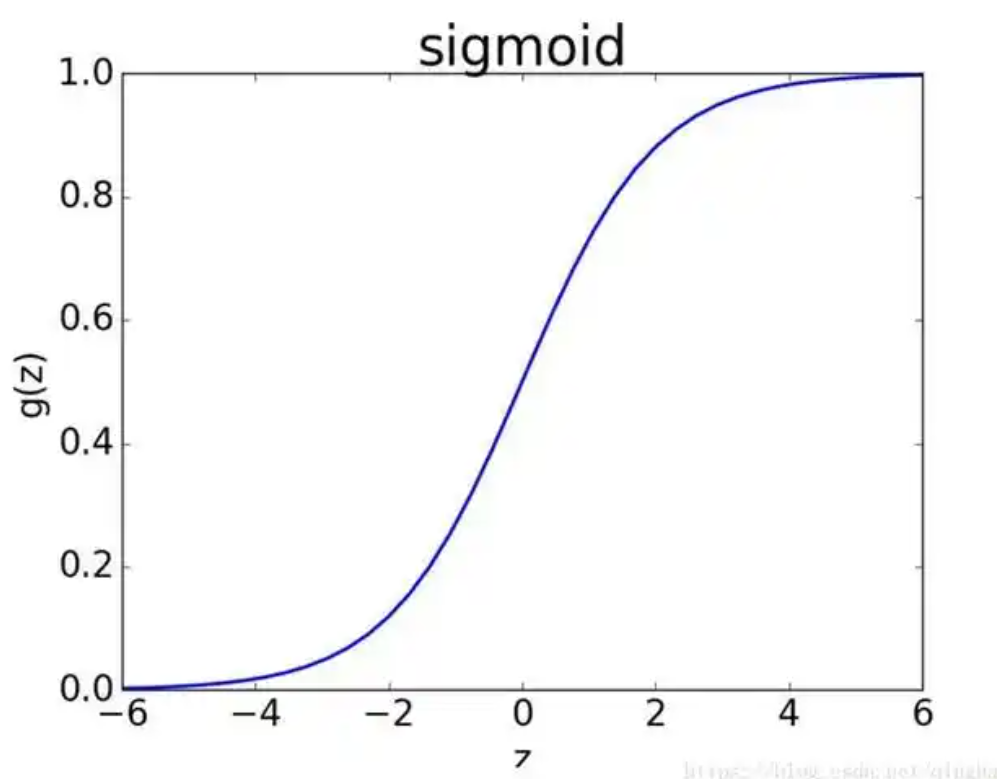

避免梯度消失 / 爆炸：
以 sigmoid 激活函数为例，其导数在输入绝对值较大时趋近于 0（如 | x|>5 时，导数≈0）。若初始权重过大，输入 x=w・input+b 可能导致激活函数进入 “饱和区”，反向传播时梯度接近 0，权重更新缓慢（梯度消失）。
类比：若初始权重是 “大值”，相当于让神经元一开始就进入 “极端状态”，失去对输入变化的敏感度。

如果梯度相对较大，就可以让变化处于sigmoid函数的非饱和区

所以其实对于不同的激活函数 ，都有对应的饱和区和非饱和区，深层网络中，饱和区会使梯度在反向传播时逐层衰减，底层参数几乎无法更新；

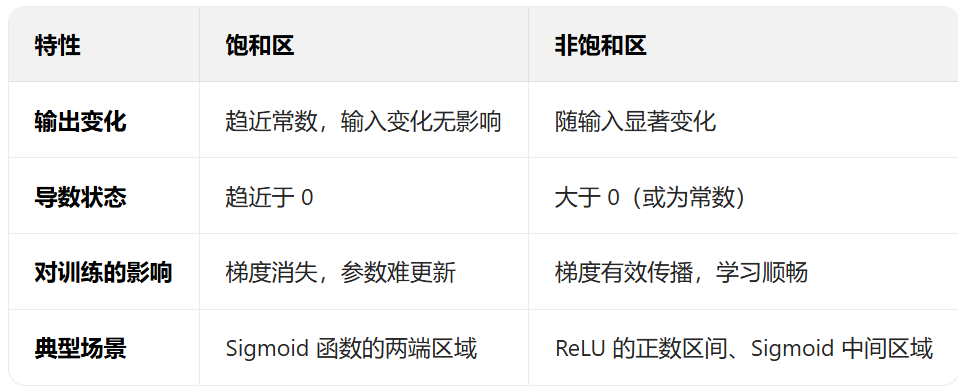

注意下，这里是wx后才会经过激活函数，是多个权重印象的结果，不是收到单个权重决定的，所以单个权重可以取负数，但是如果求和后仍然小于0，那么输出会为0


所以初始值一般不会太大，结合不同激活函数的特性，而且初始值一般是小的值。最终训练完毕可能就会出现大的差异，这样最开始让每个参数都是有用的，至于最后是不是某些参数归0（失去价值），那得看训练才知道。

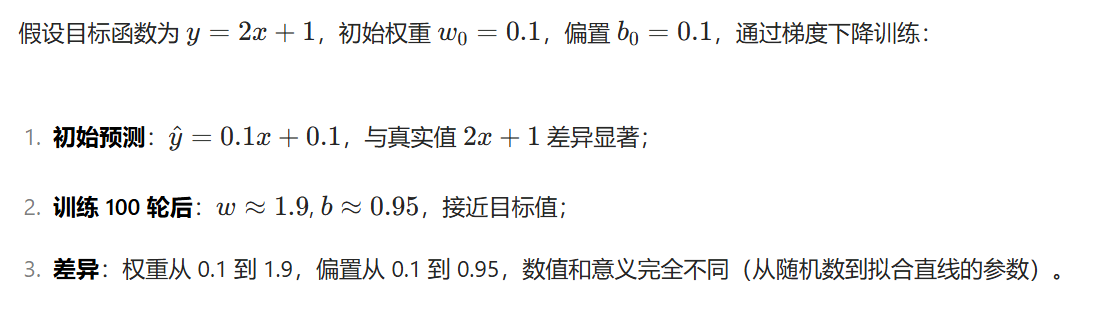

我们来观察下pytorch默认初始化的权重

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)

卷积层 权重统计:
  均值: -0.005068
  标准差: 0.109001
  理论标准差 (Kaiming): 0.816497

全连接层 权重统计:
  均值: -0.000031
  标准差: 0.009038
  理论标准差 (Kaiming): 0.022097


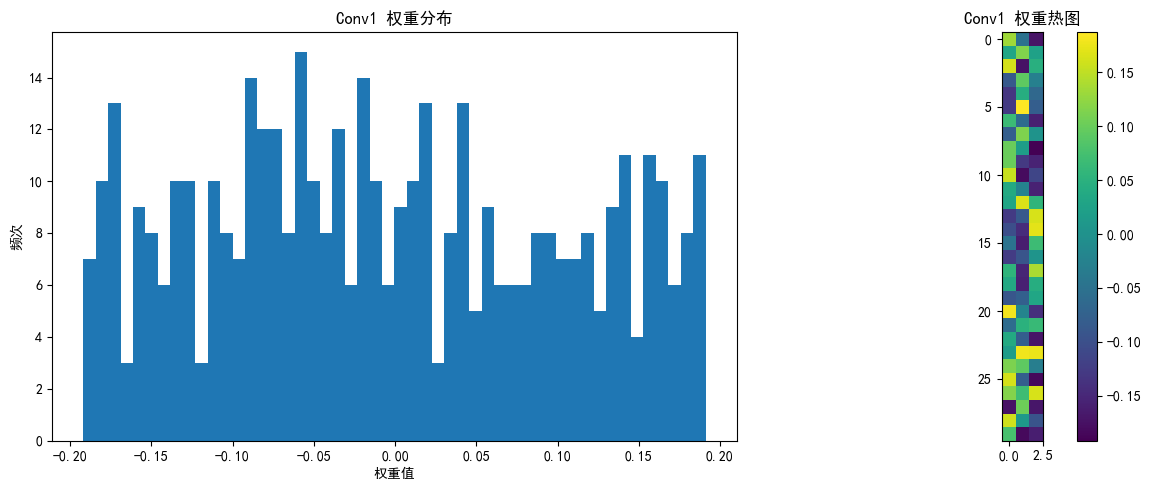

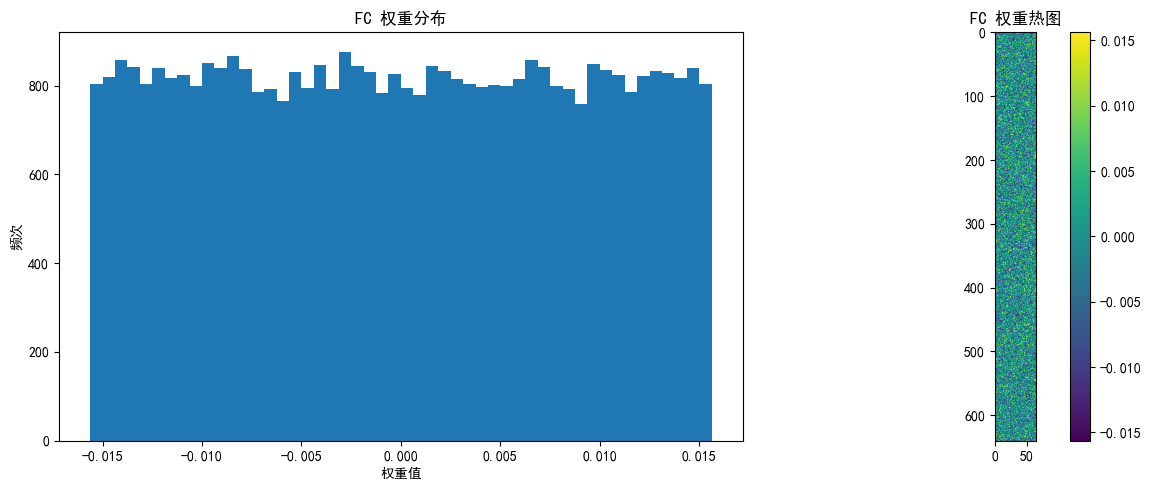

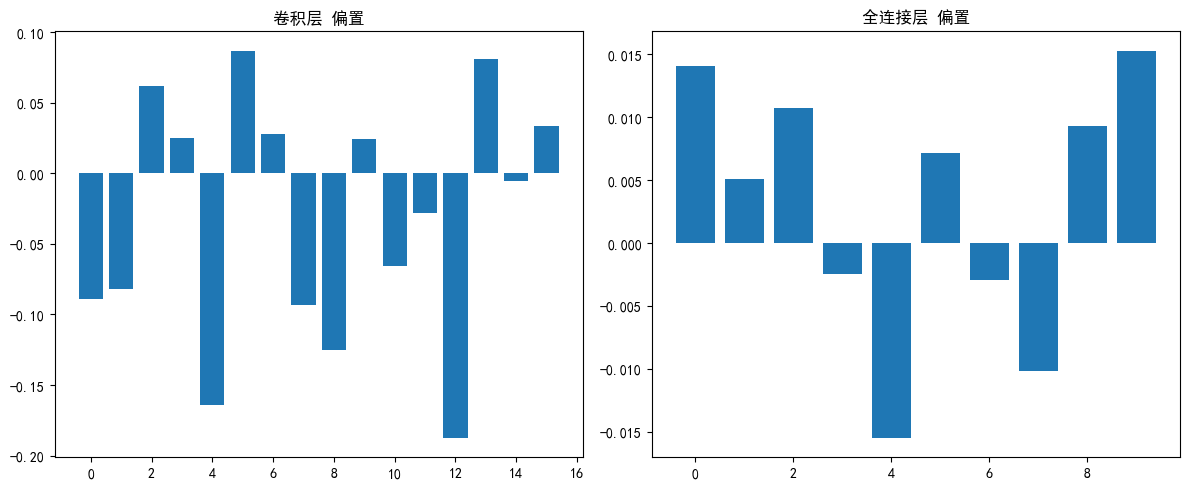


偏置统计:
卷积层偏置 均值: -0.031176
卷积层偏置 标准差: 0.086302
全连接层偏置 均值: 0.003063
全连接层偏置 标准差: 0.010418


In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义极简CNN模型（仅1个卷积层+1个全连接层）
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # 卷积层：输入3通道，输出16通道，卷积核3x3
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        
        # 池化层：2x2窗口，尺寸减半
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # 全连接层：展平后连接到10个输出（对应10个类别）
        # 输入尺寸：16通道 × 16x16特征图 = 16×16×16=4096
        self.fc = nn.Linear(16 * 16 * 16, 10)
    
    def forward(self, x):
        # 卷积+池化
        x = self.pool(self.conv1(x))  # 输出尺寸: [batch, 16, 16, 16]
        
        # 展平
        x = x.view(-1, 16 * 16 * 16)  # 展平为: [batch, 4096]
        
        # 全连接
        x = self.fc(x)  # 输出尺寸: [batch, 10]
        
        return x

# 初始化模型
model = SimpleCNN()
model = model.to(device)

# 查看模型结构
print(model)

# 查看初始权重统计信息
def print_weight_stats(model):
    # 卷积层
    conv_weights = model.conv1.weight.data
    print("\n卷积层 权重统计:")
    print(f"  均值: {conv_weights.mean().item():.6f}")
    print(f"  标准差: {conv_weights.std().item():.6f}")
    print(f"  理论标准差 (Kaiming): {np.sqrt(2/3):.6f}")  # 输入通道数为3
    
    # 全连接层
    fc_weights = model.fc.weight.data
    print("\n全连接层 权重统计:")
    print(f"  均值: {fc_weights.mean().item():.6f}")
    print(f"  标准差: {fc_weights.std().item():.6f}")
    print(f"  理论标准差 (Kaiming): {np.sqrt(2/(16*16*16)):.6f}")

# 改进的可视化权重分布函数
def visualize_weights(model, layer_name, weights, save_path=None):
    plt.figure(figsize=(12, 5))
    
    # 权重直方图
    plt.subplot(1, 2, 1)
    plt.hist(weights.cpu().numpy().flatten(), bins=50)
    plt.title(f'{layer_name} 权重分布')
    plt.xlabel('权重值')
    plt.ylabel('频次')
    
    # 权重热图
    plt.subplot(1, 2, 2)
    if len(weights.shape) == 4:  # 卷积层权重 [out_channels, in_channels, kernel_size, kernel_size]
        # 只显示第一个输入通道的前10个滤波器
        w = weights[:10, 0].cpu().numpy()
        plt.imshow(w.reshape(-1, weights.shape[2]), cmap='viridis')
    else:  # 全连接层权重 [out_features, in_features]
        # 只显示前10个神经元的权重，重塑为更合理的矩形
        w = weights[:10].cpu().numpy()
        
        # 计算更合理的二维形状（尝试接近正方形）
        n_features = w.shape[1]
        side_length = int(np.sqrt(n_features))
        
        # 如果不能完美整除，添加零填充使能重塑
        if n_features % side_length != 0:
            new_size = (side_length + 1) * side_length
            w_padded = np.zeros((w.shape[0], new_size))
            w_padded[:, :n_features] = w
            w = w_padded
        
        # 重塑并显示
        plt.imshow(w.reshape(w.shape[0] * side_length, -1), cmap='viridis')
    
    plt.colorbar()
    plt.title(f'{layer_name} 权重热图')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_{layer_name}.png')
    plt.show()

# 打印权重统计
print_weight_stats(model)

# 可视化各层权重
visualize_weights(model, "Conv1", model.conv1.weight.data, "initial_weights")
visualize_weights(model, "FC", model.fc.weight.data, "initial_weights")

# 可视化偏置
plt.figure(figsize=(12, 5))

# 卷积层偏置
conv_bias = model.conv1.bias.data
plt.subplot(1, 2, 1)
plt.bar(range(len(conv_bias)), conv_bias.cpu().numpy())
plt.title('卷积层 偏置')

# 全连接层偏置
fc_bias = model.fc.bias.data
plt.subplot(1, 2, 2)
plt.bar(range(len(fc_bias)), fc_bias.cpu().numpy())
plt.title('全连接层 偏置')

plt.tight_layout()
plt.savefig('biases_initial.png')
plt.show()

print("\n偏置统计:")
print(f"卷积层偏置 均值: {conv_bias.mean().item():.6f}")
print(f"卷积层偏置 标准差: {conv_bias.std().item():.6f}")
print(f"全连接层偏置 均值: {fc_bias.mean().item():.6f}")
print(f"全连接层偏置 标准差: {fc_bias.std().item():.6f}")


上图怎么看自行询问ai

那我们监控权重图的目的是什么呢？

训练时，权重会随反向传播迭代更新。通过权重分布图，能直观看到其从初始化（如随机分布）到逐渐收敛、形成规律模式的动态变化，理解模型如何一步步 “学习” 特征 。比如，卷积层权重初期杂乱，训练后可能聚焦于边缘、纹理等特定模式。

识别梯度异常：
1. 梯度消失：若权重分布越来越集中在 0 附近，且更新幅度极小，可能是梯度消失，模型难学到有效特征（比如深层网络用 Sigmoid 激活易出现 ）。
2. 梯度爆炸：权重值突然大幅震荡、超出合理范围（比如从 [-0.1, 0.1] 跳到 [-10, 10] ），要警惕梯度爆炸，可能让训练崩溃。

借助tensorboard可以看到训练过程中权重图的变化

铺垫了这么多 我们也该进入正题，来回顾一下对于卷积神经网络到底有哪些超参数，以及如何调参

## 神经网络调参指南

大部分时候，由于光是固定超参数的情况下，训练完模型就已经很耗时了，所以正常而言，基本不会采用传统机器学习的那些超参数方法，网格、贝叶斯、optuna之类的，看到一些博主用这些写文案啥的，感觉这些人都是脑子有问题的，估计也没学过机器学习直接就学深度学习了，搞混了二者的关系。

工业界卡特别多的情况下，可能可以考虑，尤其是在探究一个新架构的时候，我们直接忽视这些即可，只有手动调参这一条路。

#### 参数的分类

之前我们介绍过了，参数=外参（实例化的手动指定的）+内参，其中我们把外参定义为超参数，也就是不需要数据驱动的那些参数

通常可以将超参数分为三类：网络参数、优化参数、正则化参数。

- **网络参数**：包括网络层之间的交互方式（如相加、相乘或串接）、卷积核的数量和尺寸、网络层数（深度）和激活函数等。
- **优化参数**：一般指学习率、批样本数量、不同优化器的参数及部分损失函数的可调参数。
- **正则化参数**：如权重衰减系数、丢弃比率（dropout）。


超参数调优的目的是优化模型，找到最优解与正则项之间的关系。网络模型优化的目的是找到全局最优解（或相对更好的局部最优解），而正则项则希望模型能更好地拟合到最优。两者虽然存在一定对立，但目标是一致的，即最小化期望风险。模型优化希望最小化经验风险，但容易过拟合，而正则项用来约束模型复杂度。因此，如何平衡两者关系，得到最优或较优的解，就是超参数调整的目标。


#### 调参顺序

调参遵循 “先保证模型能训练（基础配置）→ 再提升性能（核心参数）→ 最后抑制过拟合（正则化）” 的思路，类似 “先建框架，再装修，最后修细节”。

我们之前的课上，主要都是停留在第一步，先跑起来，如果想要更进一步提高精度，才是这些调参指南。所以下面顺序建立在已经跑通了的基础上。

1. 参数初始化----有预训练的参数直接起飞
2. batchsize---测试下能允许的最高值
3. epoch---这个不必多说，默认都是训练到收敛位置，可以采取早停策略
4. 学习率与调度器----收益最高，因为鞍点太多了，模型越复杂鞍点越多
5. 模型结构----消融实验或者对照试验
6. 损失函数---选择比较少，试出来一个即可，高手可以自己构建
7. 激活函数---选择同样较少
8. 正则化参数---主要是droupout，等到过拟合了用，上述所有步骤都为了让模型过拟合

这个调参顺序并不固定，而且也不是按照重要度来选择，是按照方便程度来选择，比如选择少的选完后，会减小后续实验的成本。

#### 初始化参数

预训练参数是最好的参数初始化方法，在训练前先找找类似的论文有无预训练参数，其次是Xavir，尤其是小数据集的场景，多找论文找到预训练模型是最好的做法。关于预训练参数，我们介绍过了，优先动深层的参数，因为浅层是通用的；其次是学习率要采取分阶段的策略。

如果从0开始训练的话，PyTorch 默认用 Kaiming 初始化（适配 ReLU）或 Xavier 初始化（适配 Sigmoid/Tanh）。

#### bitchsize的选择

一般学生党资源都有限，所以基本都是bitchsize不够用的情况，富哥当我没说。
当Batch Size 太小的时候，模型每次更新学到的东西太少了，很可能白学了因为缺少全局思维。所以尽可能高一点，16的倍数即可，越大越好。




#### 学习率调整

学习率就是参数更新的步长，LR 过大→不好收敛；LR 过小→训练停滞（陷入局部最优）

一般最开始用adam快速收敛，然后sgd收尾，一般精度会高一点；只能选一个就adam配合调度器使用。比如 CosineAnnealingLR余弦退火调度器、StepLR固定步长衰减调度器，比较经典的搭配就是Adam + ReduceLROnPlateau，SGD + CosineAnnealing，或者Adam → SGD + StepLR。

比如最开始随便选了做了一组，后面为了刷精度就可以考虑选择更精细化的策略了

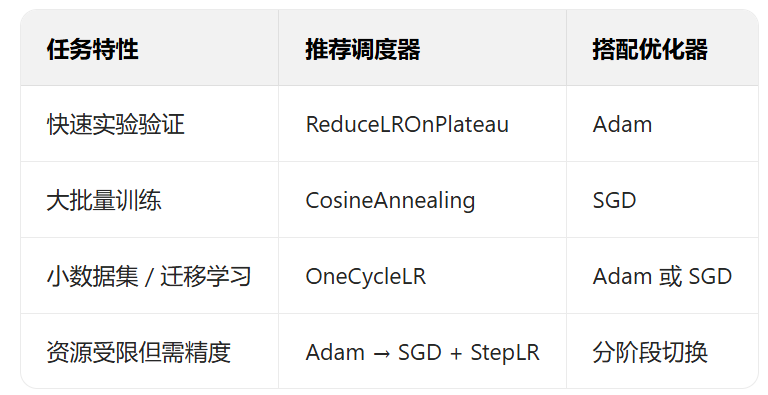

#### 激活函数的选择
视情况选择，一般默认relu或者其变体，如leaky relu，再或者用tanh。只有二分类任务最后的输出层用sigmoid，多分类任务用softmax，其他全部用relu即可。此外，还有特殊场景下的，比如GELU（适配 Transformer）

#### 损失函数的选择

大部分我们目前接触的任务都是单个损失函数构成的，正常选即可

分类任务：
1. 交叉熵损失函数Cross-Entropy Loss--多分类场景
2. 二元交叉熵损失函数Binary Cross-Entropy Loss--二分类场景
3. Focal Loss----类别不平衡场景

注意点：
- CrossEntropyLoss内置 Softmax，输入应为原始 logits（非概率）。
- BCEWithLogitsLoss内置 Sigmoid，输入应为原始 logits。
- 若评价指标为准确率，用交叉熵损失；若为 F1 分数，考虑 Focal Loss 或自定义损失。

回归任务
1. 均方误差MSE
2. 绝对误差MAE
这个也要根据场景和数据特点来选，不同损失受到异常值的影响程度不同

此外，还有一些序列任务的损失、生成任务的损失等等，以后再提


后面会遇到一个任务中有多个损失函数构成，比如加权成一个大的损失函数，就需要注意到二者的权重配比还有数量级的差异。





#### 模型架构中的参数

比如卷积核尺寸等，一般就是7*7、5*5、3*3这种奇数对构成，其实我觉得无所谓，最开始不要用太过分的下采样即可。

神经元的参数，直接用 Kaiming 初始化（适配 ReLU，PyTorch 默认）或 Xavier 初始化（适配 Sigmoid/Tanh）。

#### 正则化系数

droupout一般控制在0.2-0.5之间，这里说一下小技巧，先追求过拟合后追求泛化性。也就是说先把模型做到过拟合，然后在慢慢增加正则化程度。

正则化中，如果train的loss可以很低，但是val的loss还是很高，则说明泛化能力不强，优先让模型过拟合，在考虑加大正则化提高泛化能力，可以分模块来droupout，可以确定具体是那部分参数导致过拟合，这里还有个小trick是引入残差链接后再利用droupout

L2权重衰减这个在优化器中就有，这里提一下，也可以算是正则化吧。

#### 其他补充

对于复杂的项目，尽可能直接对着别人已经可以跑通的源码来改。----注意是可以跑通的，目前有很多论文的开源都是假开源。

在调参过程中可以监控tensorboard来关注训练过程。

无论怎么调参，提升的都是相对较小，优先考虑数据+特征工程上做文章。还有很多试验灌水的方法，自行搜索即可。实际上这些都是小问题，不做实验直接出结果的都大有人在，难绷

今天说的内容其实相对而言比较基础，非常多的trick现在提也没有价值，主要都是随便一试出来了好结果然后编个故事，不具有可以系统化标准化的理解，掌握到今天说的这个程度够用咯.大家现阶段能把复杂的模型跑通和理解已经实属不易。